In [1]:
%matplotlib inline
from matplotlib import style
style.use('fivethirtyeight')
import matplotlib.pyplot as plt

In [2]:
import numpy as np
import pandas as pd
import datetime as dt

# Reflect Tables into SQLAlchemy ORM

In [3]:
# Python SQL toolkit and Object Relational Mapper
import sqlalchemy
from sqlalchemy.ext.automap import automap_base
from sqlalchemy.orm import Session
from sqlalchemy import create_engine, func, desc

In [4]:
# create engine to hawaii.sqlite
engine = create_engine("sqlite:///Resources/hawaii.sqlite")

In [5]:
# reflect an existing database into a new model
Base = automap_base()

# reflect the tables
Base.prepare(autoload_with=engine)

In [6]:
# View all of the classes that automap found
print(Base.classes.keys())

['measurement', 'station']


In [7]:
# Save references to each table
Measurement = Base.classes.measurement
Station = Base.classes.station

In [8]:
# Create our session (link) from Python to the DB
session = Session(bind=engine)

# Exploratory Precipitation Analysis

In [9]:
# Find the most recent date in the data set.
recent_date = session.query(Measurement.date).order_by(desc(Measurement.date)).first()

print(recent_date)

('2017-08-23',)


2016-08-23


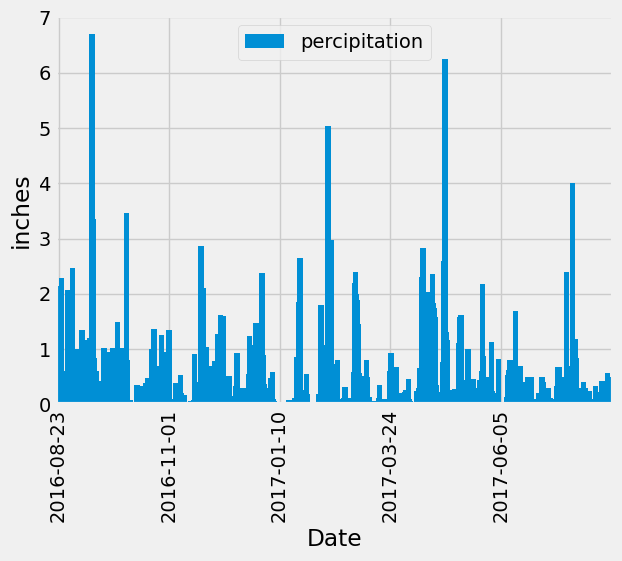

In [10]:
# Design a query to retrieve the last 12 months of precipitation data and plot the results. 
# Starting from the most recent data point in the database. 

# Calculate the date one year from the last date in data set.
recent_date_dt = dt.datetime.strptime(recent_date[0], '%Y-%m-%d') 
date_one_year_from_last = recent_date_dt - dt.timedelta(days = 365)
print(date_one_year_from_last.date())

# Perform a query to retrieve the data and precipitation scores
precipitation_scores = session.query(Measurement.date, Measurement.prcp).filter(
    Measurement.date >= date_one_year_from_last.date()).all()

# Save the query results as a Pandas DataFrame. Explicitly set the column names
precipitation_df = pd.DataFrame(precipitation_scores)
precipitation_df = precipitation_df.rename(columns = {'prcp' : 'percipitation', 'date' : 'Date'})
precipitation_df = precipitation_df.dropna()

# Sort the dataframe by date
precipitation_df = precipitation_df.sort_values("Date", ascending=True)

# Covert Date column to String format
precipitation_df["Date"] = pd.to_datetime(precipitation_df["Date"])
precipitation_df["Date"] = precipitation_df["Date"].dt.strftime("%Y-%m-%d")

# Use Pandas Plotting with Matplotlib to plot the data
precipitation_df.plot(kind="bar", x="Date", y="percipitation", width=20, grid=True)
plt.locator_params(axis="x", tight=True, nbins=5)
plt.ylabel("inches")
plt.show()

In [11]:
# Use Pandas to calculate the summary statistics for the precipitation data
precipitation_summary_stats_df = pd.DataFrame(precipitation_df['percipitation'].describe())
precipitation_summary_stats_df

,percipitation
count,2021.000000
mean,0.177279
std,0.461190
min,0.000000
25%,0.000000
50%,0.020000
75%,0.130000
max,6.700000


# Exploratory Station Analysis

In [12]:
# Design a query to calculate the total number of stations in the dataset
total_nbr_of_stations = session.query(func.distinct(Station.name)).count()
print(total_nbr_of_stations)

9


In [13]:
# Design a query to find the most active stations (i.e. which stations have the most rows?)
# List the stations and their counts in descending order.

most_active_stations = session.query(
    Measurement.station,func.count(Measurement.station).label('station_count')).group_by(
    Measurement.station).order_by(desc('station_count'))

for s in most_active_stations:
    print(s)

('USC00519281', 2772)
('USC00519397', 2724)
('USC00513117', 2709)
('USC00519523', 2669)
('USC00516128', 2612)
('USC00514830', 2202)
('USC00511918', 1979)
('USC00517948', 1372)
('USC00518838', 511)


In [14]:
# Using the most active station id from the previous query, calculate the lowest, highest, and average temperature.

# Find the most active station id
most_active_station=most_active_stations[0][0]

print(most_active_station)

# Query for lowest, highest and average temperature
most_active_station_temp_stats = session.query(func.min(Measurement.tobs), 
                                               func.max(Measurement.tobs),
                                              func.avg(Measurement.tobs))\
.filter(Measurement.station == most_active_station).all()

print(most_active_station_temp_stats)

USC00519281
[(54.0, 85.0, 71.66378066378067)]


<Axes: xlabel='Temperature', ylabel='Frequency'>

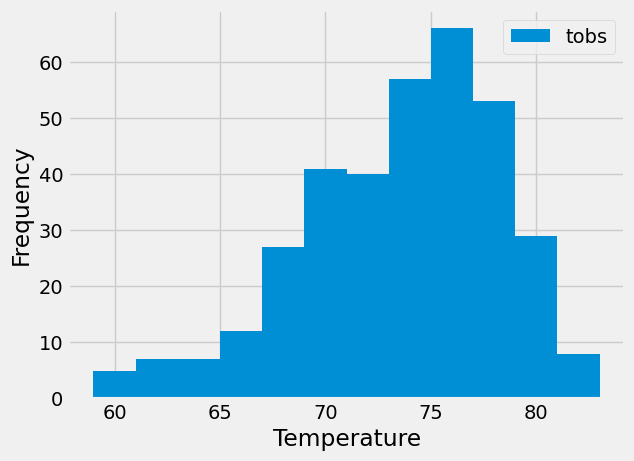

In [15]:
# Using the most active station id
# Query the last 12 months of temperature observation data for this station and plot the results as a histogram

temp_most_active_station = session.query(Measurement.tobs).filter(
    Measurement.station == most_active_station).filter(
    Measurement.date >= date_one_year_from_last.date()).all()

# Create a Dataframe using the results obtained by running the query
temp_most_active_station_df = pd.DataFrame(temp_most_active_station)

# Plot the results as a historgram
temp_most_active_station_df["tobs"].plot.hist(bins=12, xlabel='Temperature', legend=True)



# Close Session

In [16]:
# Close Session
session.close()